In [ ]:
pip install pandas scikit-learn matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
file_path = "McDonald_s_Reviews.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [ ]:
df_clean = df[['review', 'rating']].dropna()
df_clean = df_clean[df_clean['review'].str.strip() != '']
df_clean['rating'] = df_clean['rating'].str.extract('(\d)').astype(int)

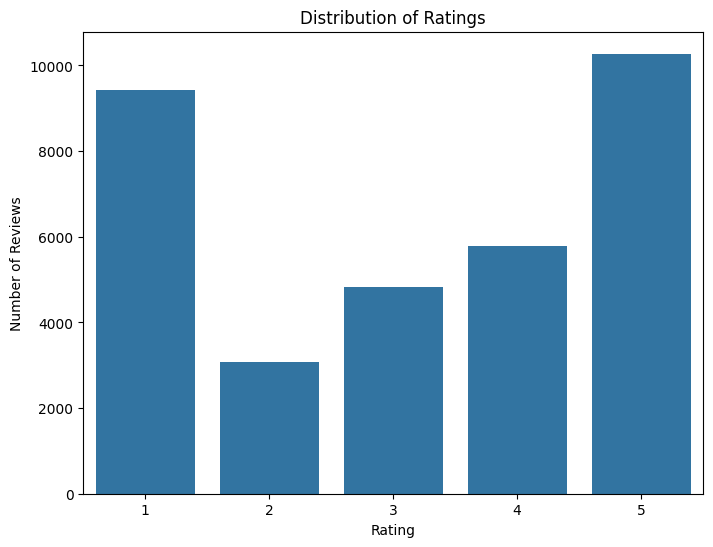

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

rating_counts = df_clean['rating'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Ratings')
plt.show()

In [ ]:
# Convert ratings to sentiment labels
def get_sentiment(r):
    if r <= 2:
        return 'negative'
    elif r == 3:
        return 'neutral'
    else:
        return 'positive'

df_clean['sentiment'] = df_clean['rating'].apply(get_sentiment)

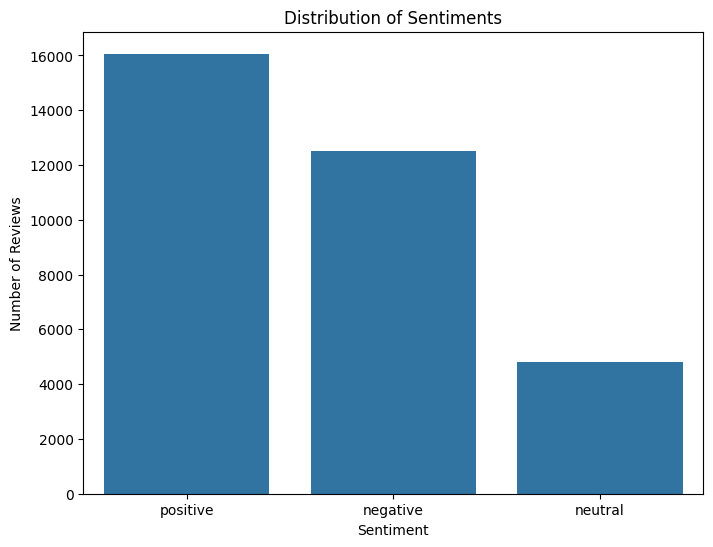

In [ ]:

sentiment_counts = df_clean['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiments')
plt.show()


In [ ]:
# Prepare data
X = df_clean['review'].values
y = df_clean['sentiment'].values

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))
y_encoded = tf.keras.utils.to_categorical(y_encoded, num_classes)


In [ ]:

# Tokenize and pad sequences
max_words = 5000
max_len = 100

In [ ]:
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len)

In [ ]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)


In [ ]:

# Build DNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5745 - loss: 0.9285 - val_accuracy: 0.7627 - val_loss: 0.6624
Epoch 2/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7430 - loss: 0.6588 - val_accuracy: 0.7294 - val_loss: 0.6725
Epoch 3/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7637 - loss: 0.5892 - val_accuracy: 0.7691 - val_loss: 0.5541
Epoch 4/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8041 - loss: 0.5146 - val_accuracy: 0.7949 - val_loss: 0.5420
Epoch 5/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8229 - loss: 0.4754 - val_accuracy: 0.7893 - val_loss: 0.5542


In [ ]:
# Evaluate
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:

              precision    recall  f1-score   support

    negative       0.72      0.94      0.82      2543
     neutral       0.62      0.40      0.48       939
    positive       0.91      0.78      0.84      3198

    accuracy                           0.79      6680
   macro avg       0.75      0.71      0.71      6680
weighted avg       0.80      0.79      0.78      6680



In [ ]:
# ---- PREDICTION FUNCTION ----
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(pad)
    sentiment = label_encoder.inverse_transform([np.argmax(pred)])
    return sentiment[0]

In [ ]:
# ---- USER INPUT LOOP ----
while True:
    user_input = input("Enter a customer review (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    sentiment = predict_sentiment(user_input)
    print(f"Predicted Sentiment: {sentiment}\n")

Enter a customer review (or type 'exit' to quit): this is a very good store 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Sentiment: positive

Enter a customer review (or type 'exit' to quit): this is a very shitty restaurant 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Sentiment: negative

Enter a customer review (or type 'exit' to quit): rubbish
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Sentiment: negative

Enter a customer review (or type 'exit' to quit): fuck
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Sentiment: negative

Enter a customer review (or type 'exit' to quit): dumbass
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Sentiment: negative

Enter a customer review (or type 'exit' to quit): moron
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Sentiment: negative

